In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from icedef import statoil_arcticnet_data as sd
from icedef import plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# BEACON

In [7]:
df_by_id = {}
for beacon_csv_filename in sd.beacon_csv_filenames:
    df = sd.get_df(sd.beacon_dir_path + beacon_csv_filename)
    beacon_id = df['BeaconID'][0]
    df_by_id[beacon_id] = df

In [22]:
latlons = []
labels = []

for beacon_id, df in df_by_id.items():
    lats, lons = df['Latitude'].values, df['Longitude'].values
    latlons.append([lats, lons])
    labels.append(beacon_id)

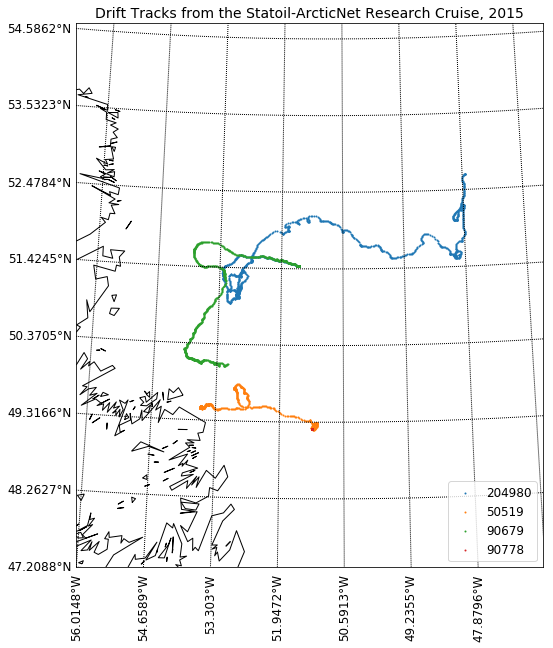

In [37]:
title = 'Drift Tracks from the Statoil-ArcticNet Research Cruise, 2015'
pads = [2] * 4
kwargs = {'pads': pads, 'labels': labels, 'title': title}
fig, ax = plot.plot_track(*latlons, **kwargs)

In [35]:
stats_df = pd.DataFrame(columns=['beacon_id', 'start_time', 'end_time', 'time_length', 
                                 'start_latitude', 'start_longitude',
                                 'end_latitude', 'end_longitude'])
for beacon_id, df in df_by_id.items():
    start_time = df['DataDate_UTC'][0]
    end_time = df['DataDate_UTC'][len(df['DataDate_UTC']) - 1]
    start_lat = df['Latitude'][0]
    end_lat = df['Latitude'][len(df['Latitude']) - 1]
    start_lon = df['Longitude'][0]
    end_lon = df['Longitude'][len(df['Longitude']) - 1]
    stats_df.loc[len(stats_df)] = [beacon_id, start_time, end_time, end_time - start_time, 
                                   start_lat, start_lon, end_lat, end_lon]

In [36]:
stats_df

,beacon_id,start_time,end_time,time_length,start_latitude,start_longitude,end_latitude,end_longitude
0,204980,2015-04-24 15:16:06,2015-06-13 09:33:42,49 days 18:17:36,51.45991,-51.55144,52.69404,-47.82604
1,50519,2015-04-23 18:48:37,2015-06-01 02:09:54,38 days 07:21:17,49.22403,-51.25820,49.46962,-53.58547
2,90679,2015-04-24 15:21:03,2015-05-25 01:20:03,30 days 09:59:00,51.46240,-51.55285,50.09155,-53.06512
3,90778,2015-04-23 18:53:57,2015-04-23 19:57:39,0 days 01:03:42,49.22347,-51.25890,49.22226,-51.24820


# AVOS

In [38]:
avos_df = sd.get_avos_df()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


In [44]:
# Note this takes really long to run
#plot.plot_track([avos_df['latitude'].values, avos_df['longitude'].values])

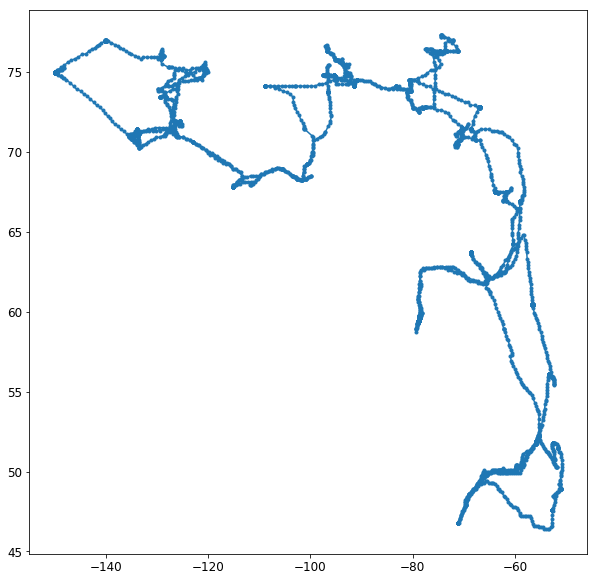

In [46]:
plt.plot(avos_df['longitude'], avos_df['latitude'], '.-')

# ADCP

In [49]:
adcp_ds = sd.get_adcp_ds()

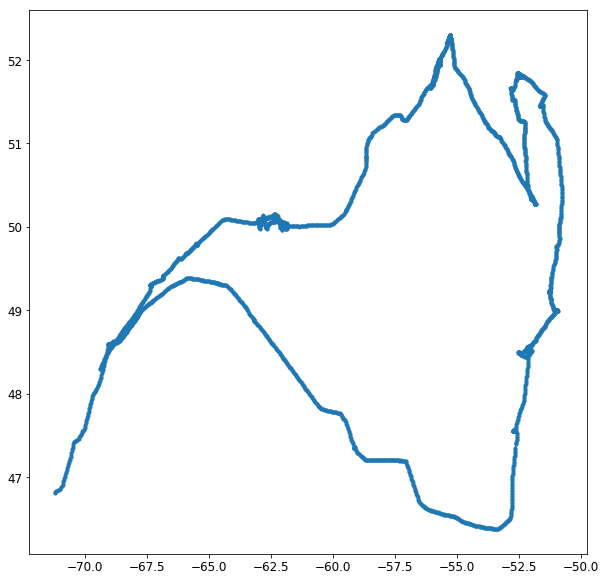

In [51]:
plt.plot(adcp_ds.longitude.values, adcp_ds.latitude.values, '.-')